In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Foreword

Multi-class image classification of natural scenes from around the world

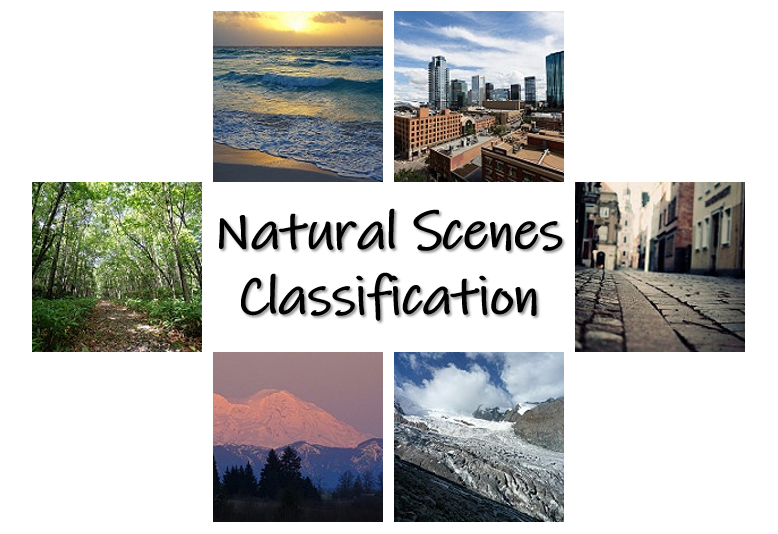

# Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import os
from os import walk

In [2]:
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session()

# The data

In [3]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_pred = '../input/intel-image-classification/seg_pred/seg_pred'
dir_test = '../input/intel-image-classification/seg_test/seg_test'
dir_train =  '../input/intel-image-classification/seg_train/seg_train'

In [4]:
# read in the names of the images in the prediction set
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


# Helper functions

In [5]:
def read_image_names_class(dpath):
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp        
    
    return dirnames, fnames

def check_class_imbalance(fnames):
    count = 0
    class_summary = {}
    for key,value in fnames.items():
        count = count + len(value)
        class_summary[key] = len(value)
        
    summary = pd.DataFrame.from_dict(class_summary, orient='index', columns=["Count"])  
    summary['CumCount'] = np.cumsum(summary['Count']) 
    summary['Class'] = summary.index
    summary['Class'] = summary['Class'].apply(class_from_key)
    
    return summary

def class_from_key(x):
    for key, value in classes.items():
        if x == value:
            return key
        
def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]
    
    return spath

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    
    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):            
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)   
            
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:
        spj.append(os.path.join(path, fnames[sp]))
    
    return spj
    
def plot_sampled_prediction_images(path, fnames):    
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)
    
    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')
    
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))    
    
    return ytrue, ypred

def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))
    
def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')
    
    parr = tf.keras.preprocessing.image.img_to_array(img)    
    tparr = tf.expand_dims(parr, axis=0)
    
    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]
    
    sns.barplot(x=x,y=y,ax=ax2)
    
    return pred

# Sample the training data

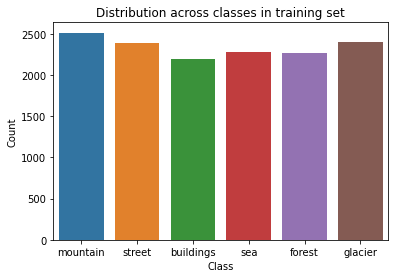

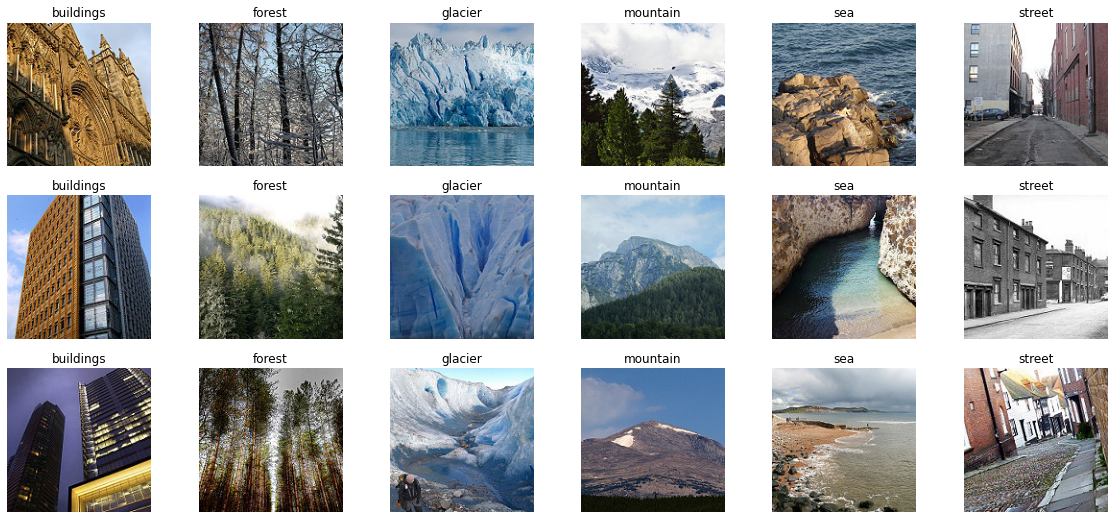

In [6]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x = 'Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

# Sample the test data

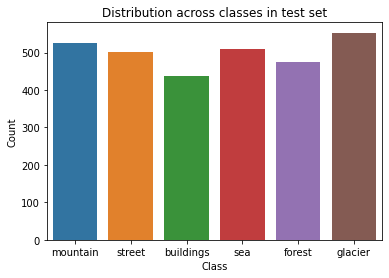

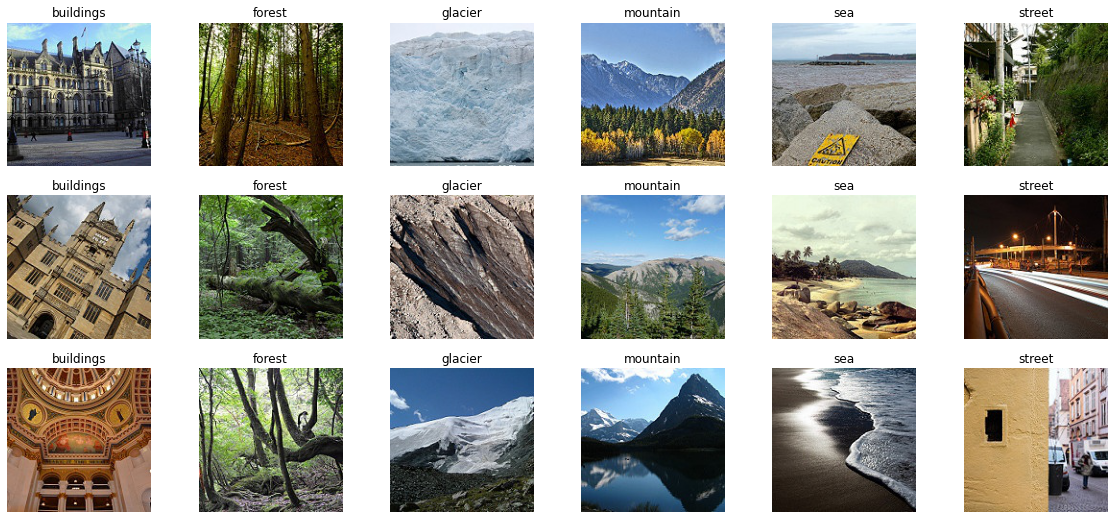

In [7]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

# Sample the prediction images

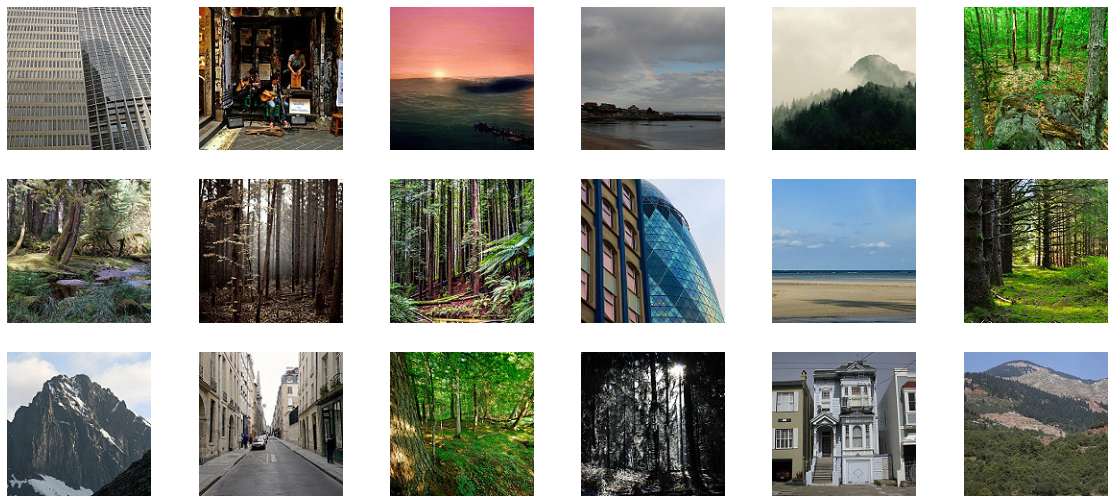

In [8]:
plot_sampled_prediction_images(dir_pred, fnames_pred)

# Load the data

In [9]:
batch = 32
shuff = True
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="training",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="validation",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# CNN Model

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

In [13]:
train_model = False
use_custom_base = False

In [14]:
if train_model and use_custom_base:
    mod = tf.keras.models.Sequential([    
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (150,150,3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1,0.3)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(1,1), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),   
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),      
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=6, activation='softmax')
            ])
    
    mets = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), 
        tf.metrics.TrueNegatives(), tf.metrics.TruePositives(), tf.metrics.FalseNegatives(), tf.metrics.FalsePositives()]
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])
    
    earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

    # traindat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, 
    #                                                           brightness_range=(-2.,2.), zoom_range=0.2, horizontal_flip=True, 
    #                                                           rescale=1./255, validation_split=0.2)
    # testdat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    # train_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="training")
    # valid_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="validation")
    # test_ds = testdat_aug.flow_from_directory(dir_test, target_size=(150,150), batch_size=batch, class_mode='categorical')

    # traindat_aug.fit(train_ds)
    
if train_model and not use_custom_base:
    pre_trained_base = VGG16(weights = 'imagenet', include_top=False)
    pre_trained_base.summary()
    pre_trained_base.trainable = False
    
    mod = tf.keras.models.Sequential([    
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (150,150,3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1,0.3)),

        pre_trained_base,

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=6, activation='softmax')
            ])
    
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])
    
    earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

# Train the CNN

In [15]:
if train_model:
    checkpoint = tf.keras.callbacks.ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_weights_only=True, mode='max')
    hist = mod.fit(train_ds, epochs=50, batch_size=batch, verbose=1, shuffle=shuff, validation_data=val_ds, callbacks=[earlystop, lr, checkpoint])
else:
    with open("../input/cnn-20210612-0700/CNN_Intel.json","r") as json_file:
        loaded_model_json = json_file.read()
        mod = tf.keras.models.model_from_json(loaded_model_json)
        mod.load_weights("../input/cnn-20210612-0700/model_weights.h5")
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

Epoch 1/50
351/351 [==============================] - 735s 2s/step - loss: 2.2838 - accuracy: 0.5946 - val_loss: 0.5384 - val_accuracy: 0.7897

Epoch 00001: saving model to model_weights.h5
Epoch 2/50
351/351 [==============================] - 654s 2s/step - loss: 0.5954 - accuracy: 0.7823 - val_loss: 0.5665 - val_accuracy: 0.7869

Epoch 00003: saving model to model_weights.h5
Epoch 4/50
351/351 [==============================] - 654s 2s/step - loss: 0.5770 - accuracy: 0.7943 - val_loss: 0.4402 - val_accuracy: 0.8382

Epoch 00004: saving model to model_weights.h5
Epoch 5/50
351/351 [==============================] - 654s 2s/step - loss: 0.5420 - accuracy: 0.8044 - val_loss: 0.4790 - val_accuracy: 0.8311

Epoch 00005: saving model to model_weights.h5
Epoch 6/50
351/351 [==============================] - 654s 2s/step - loss: 0.5507 - accuracy: 0.7972 - val_loss: 0.4516 - val_accuracy: 0.8368

Epoch 00006: saving model to model_weights.h5
Epoch 7/50
351/351 [==============================

In [16]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   1

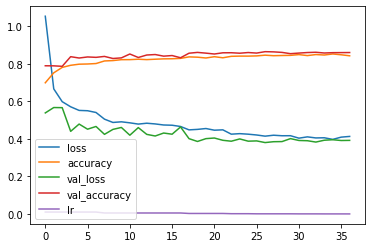

In [17]:
if train_model:
    for key in hist.history.keys():
        plt.plot(hist.history[key],label=key)
    plt.legend()
    # plt.ylim([0,1])

In [18]:
if train_model:
    model_json = mod.to_json()
    with open("CNN_Intel.json","w") as json_file:
        json_file.write(model_json)

# Dataset used for training

Found 14034 files belonging to 6 classes.
439/439 [==============================] - 665s 2s/step - loss: 0.3382 - accuracy: 0.8733


[0.33819419145584106, 0.8733077049255371]

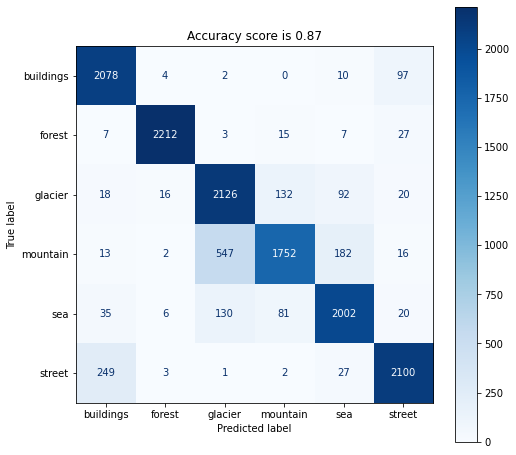

In [19]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,                                                   
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(mod, train_ds1)
plot_confMat(y_true, y_pred)

mod.evaluate(train_ds1)

# Prediction with test dataset, not seen by the model

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 142s 2s/step - loss: 0.3987 - accuracy: 0.8500


[0.3986569046974182, 0.8500000238418579]

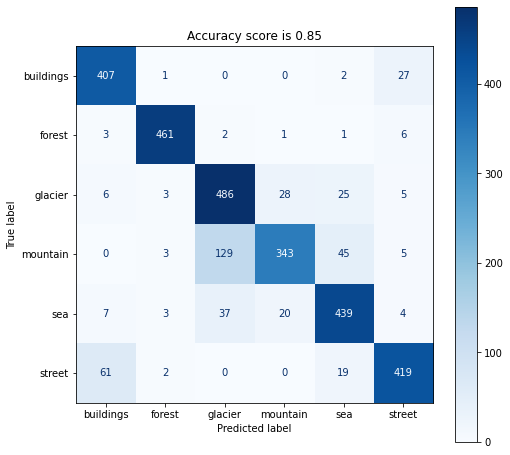

In [20]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(mod, test_ds1)
plot_confMat(y_true, y_pred)

mod.evaluate(test_ds1)

# Prediction dataset

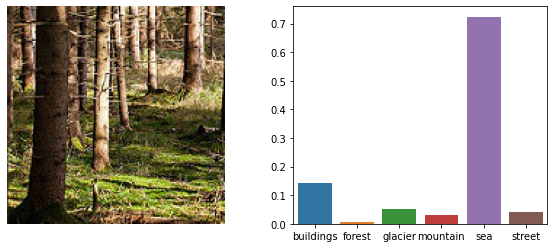

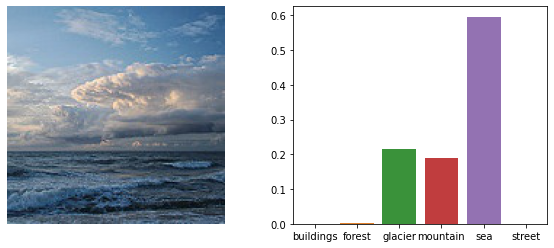

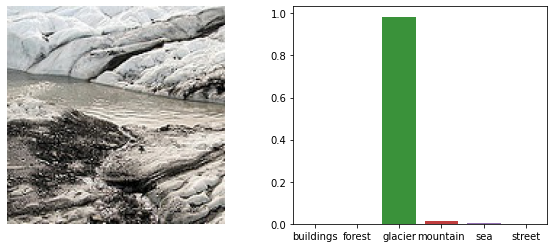

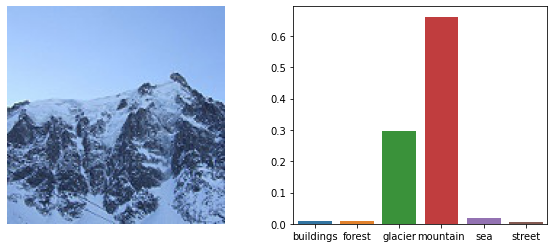

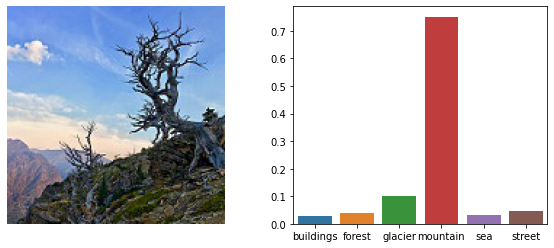

In [21]:
sp = sample_prediction_images(dir_pred, fnames_pred, 5)
for spj in sp:
    read_prepare_image_predict(spj,mod)